# 出租车运行时间预测项目
****
作者：Eden Yin

# 目录
#### 1.提出问题
#### 2.理解数据
#### 3.数据清洗
1 ) 数据预处理
* 缺失值处理
* 异常值处理

2 ) 特征工程
* 特征提取
* 特征选择

#### 4.构建模型
* 模型选择
* 调参

#### 5.方案实施

# 1. 提出问题

出租车的费用与行驶时间有很强的相关性。

此项目通过记录纽约市出租车行驶数据，以此预测单次的行驶时间。

# 2. 理解数据

## 2.1 导入数据
****
数据来自Kaggle:https://www.kaggle.com/c/nyc-taxi-trip-duration/data

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from haversine import haversine
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import holidays
from datetime import timedelta
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] #解决seaborn无法显示中文的问题

%matplotlib inline
pd.options.display.max_rows=10

In [2]:
train=pd.read_csv(r'D:\nyc_taxi\train.csv')
test=pd.read_csv(r'D:\nyc_taxi\test.csv')

## 2.1 数据说明

**id** - 每次行驶的编号

**vendor_id（卖方编号）** - 行驶记录中旅途提供者（出租车公司）的编号

**pickup_datetime(上车时间)** - 出租车开始打表的时间

**dropoff_datetime(下车时间)** - 出租车停止打表的时间

**passenger_count（乘客人数）** - 车辆内的乘客人数（驾驶员输入）

**pickup_longitude(上车经度)** - 出租车开始打表时的经度

**pickup_latitude（上车纬度）** - 出租车开始打表时的纬度

**dropoff_longitude(下车经度)** - 出租车停止打表时的经度

**dropoff_latitude（下车纬度）** - 出租车停止打表时的纬度

**store_and_fwd_flag（数据记录发送类别）** - 改字段表示，该条旅行记录是直接发送到服务器还是先储存再发送到服务器。

 * *Y=先储存，再发送=; N=直接发送*

**trip_duration（行驶时长）** - 单次旅程的行驶时间（以秒计）

# 3. 数据清洗

## 3.1 数据预处理

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


没有缺失值

### 3.1.2 异常值处理

先将异常的数据类型进行转换

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


发现异常：

1. **passenger_count** 最小为0人
2. **passenger_count**最大为9人
3. **trip_duration** 标准差特别大
4. **trip_duration** 最小为1秒
5. **trip_duration** 最大将近41天

**查看passenger_count分布**

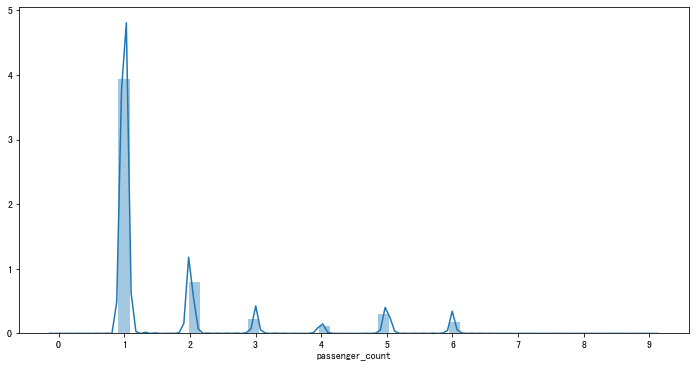

In [6]:
x_major_locator=MultipleLocator(1) 
ax=plt.subplot(1,1,1)
sns.distplot(train.passenger_count,ax=ax)
ax.figure.set_size_inches(12,6)
ax.xaxis.set_major_locator(x_major_locator)

In [7]:
train.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

乘客数量0,7,8,9为明显的离群点

考虑到所占数据比例不大，作删除处理

In [8]:
train=train[(train.passenger_count>0)]
temp=train.passenger_count.apply(lambda x: x not in [7,8,9])
train=train[temp]

**查看vendor_id**

In [9]:
train.vendor_id.value_counts()

2    780268
1    678311
Name: vendor_id, dtype: int64

发现只有1,2两个数值

推测这表示出租车公司，且只有两家

**查看trip_duration分布**

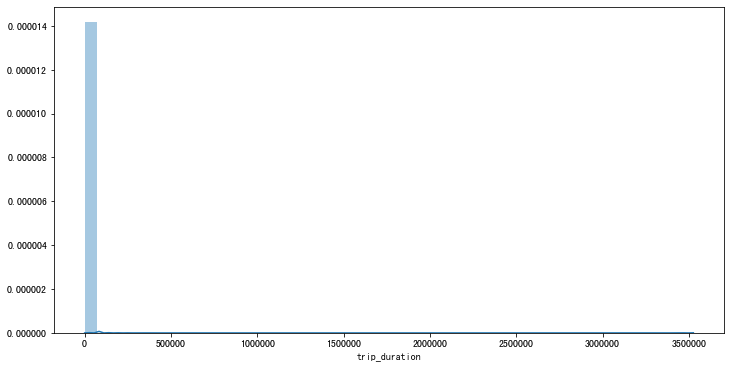

In [10]:
trip_duration=train[train.trip_duration.notnull()]['trip_duration']

plt.figure(figsize=(12,6))
sns.distplot(trip_duration)

由于异常值的数值过大，导致图形显示异常

先去除三个标准差之外的数值

In [11]:
trip_duration_drop=train[np.abs(train.trip_duration-train.trip_duration.mean())>3*train.trip_duration.std()]['trip_duration']
trip_duration=train[np.abs(train.trip_duration-train.trip_duration.mean())<=3*train.trip_duration.std()]['trip_duration']

In [12]:
len(trip_duration_drop)/len(trip_duration)

0.0014225815598551878

异常值所占比率较小，因此做删除处理

In [13]:
train=train[np.abs(train.trip_duration-train.trip_duration.mean())<=3*train.trip_duration.std()]

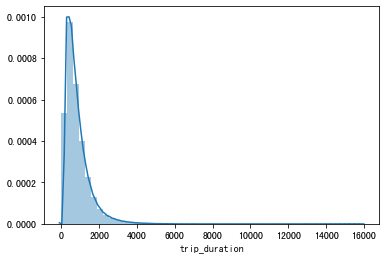

In [14]:
sns.distplot(a=trip_duration)

看到偏斜依然明显，因此做log处理

In [15]:
trip_duration_log=np.log(trip_duration)

[Text(0.5, 1.0, 'log化处理前')]

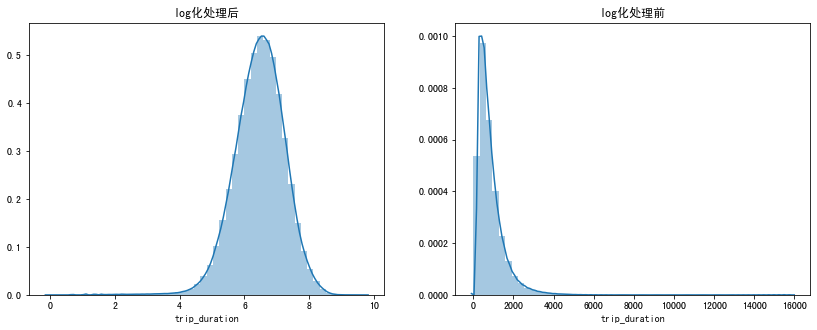

In [16]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(14,5)

sns.distplot(trip_duration_log,ax=ax[0])
sns.distplot(trip_duration,ax=ax[1])

ax[0].set(title='log化处理后')
ax[1].set(title='log化处理前')

In [17]:
# 用log化的数值代替
train['trip_duration']=trip_duration_log

**查看pickup_longitude、dropoff_longitude**

[Text(0.5, 0, ''), Text(0.5, 1.0, 'Dropoff')]

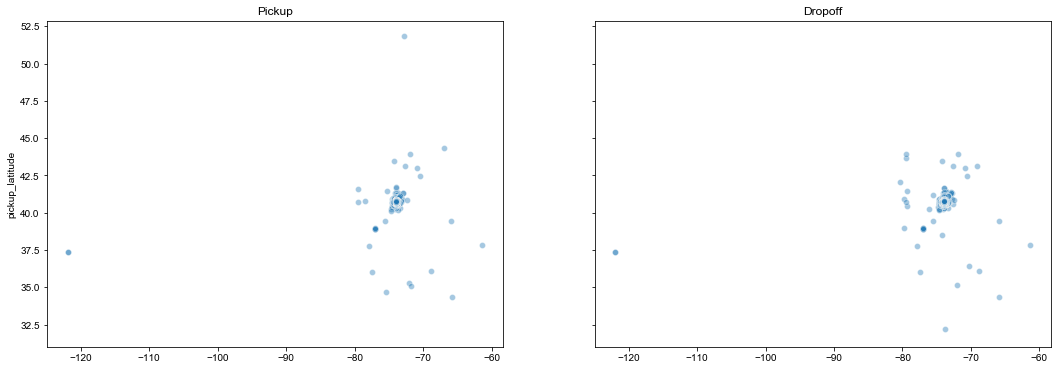

In [18]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(18,6))

sns.scatterplot(train.pickup_longitude,train.pickup_latitude,ax=ax[0],alpha=0.4)
sns.scatterplot(train.dropoff_longitude,train.dropoff_latitude,ax=ax[1],alpha=0.4)
sns.set_style('dark')

ax[0].set(title='Pickup',xlabel='')
ax[1].set(title='Dropoff',xlabel='')

可以看到有比较明显的离群点





进一步查看

In [19]:
position=train[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
position.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1456507.000,1456507.000,1456507.000,1456507.000
mean,-73.973,40.751,-73.973,40.752
std,0.071,0.033,0.071,0.036
min,-121.933,34.360,-121.933,32.181
25%,-73.992,40.737,-73.991,40.736
50%,-73.982,40.754,-73.980,40.755
75%,-73.967,40.768,-73.963,40.770
max,-61.336,51.881,-61.336,43.921


In [20]:
train[train.pickup_longitude<-110]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,-121.933,37.389,-121.933,37.389,N,7.008
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.933,37.389,-121.933,37.390,N,6.213


In [21]:
train[train.pickup_latitude>50]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.810,51.881,-73.987,40.751,N,6.675


发现以上旅途时间都仅有几秒，且上下车地点几乎一致

因此视作异常值删去

In [22]:
index_to_drop=train[(train.pickup_longitude<-110)|(train.pickup_latitude>50)].index
train=train.drop(index=index_to_drop,axis=0)

查看删去后的数据：

[Text(0.5, 0, ''), Text(0.5, 1.0, 'Dropoff')]

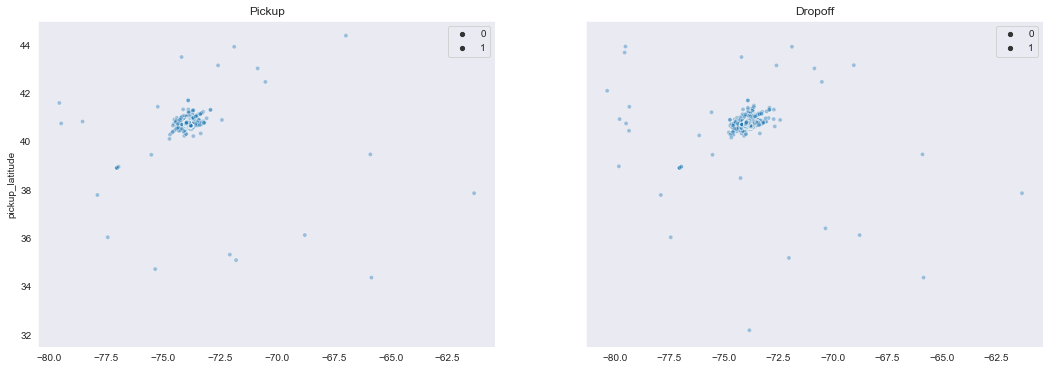

In [23]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(18,6))

sns.scatterplot(train.pickup_longitude,train.pickup_latitude,ax=ax[0],alpha=0.4,size=1)
sns.scatterplot(train.dropoff_longitude,train.dropoff_latitude,ax=ax[1],alpha=0.4,size=1)
sns.set_style('dark')

ax[0].set(title='Pickup',xlabel='')
ax[1].set(title='Dropoff',xlabel='')

发现依然存在离群点，因此进行进一步修剪：

In [24]:
max_v=99.999
min_v=0.001
#求出边界
max_pick_lat=np.percentile(train.pickup_latitude,max_v)
min_pick_lat=np.percentile(train.pickup_latitude,min_v)
max_pick_long=np.percentile(train.pickup_longitude,max_v)
min_pick_long=np.percentile(train.pickup_longitude,min_v)
max_drop_lat=np.percentile(train.dropoff_latitude,max_v)
min_drop_lat=np.percentile(train.dropoff_latitude,min_v)
max_drop_long=np.percentile(train.dropoff_latitude,max_v)
min_drop_long=np.percentile(train.dropoff_latitude,min_v)
#移除离群点
train=train[train.pickup_latitude.between(min_pick_lat,max_pick_lat,inclusive=True)]
train=train[train.pickup_longitude.between(min_pick_long,max_pick_long,inclusive=True)]
train=train[train.dropoff_latitude.between(min_drop_lat,max_drop_lat,inclusive=True)]
train=train[train.dropoff_longitude.between(min_pick_long,max_pick_long,inclusive=True)]

[Text(0.5, 0, ''), Text(0.5, 1.0, 'Dropoff')]

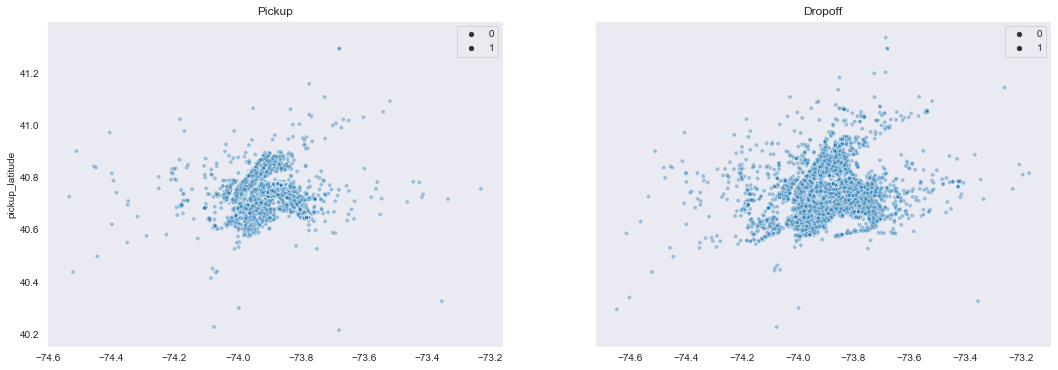

In [26]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(18,6))
n=int(len(train)/3)
sns.scatterplot(train.pickup_longitude[:n],train.pickup_latitude[:n],ax=ax[0],alpha=0.4,size=1)
sns.scatterplot(train.dropoff_longitude[:n],train.dropoff_latitude[:n],ax=ax[1],alpha=0.4,size=1)
sns.set_style('dark')

ax[0].set(title='Pickup',xlabel='')
ax[1].set(title='Dropoff',xlabel='')

可以看出：

数据较为集中，且看得出纽约市大致轮廓

## 3.2 特征工程

### 3.2.1 特征提取

**处理时间序列：**

In [27]:
len(train.index)

1456444

In [28]:
full=pd.concat([train,test],axis=0,ignore_index=True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [29]:
full['pickup_datetime']=pd.to_datetime(full['pickup_datetime'])
full['dropoff_datetime']=pd.to_datetime(full['dropoff_datetime'])

In [30]:
#weekend列，1表示是周末；0表示不是
#只需要对pickup做处理
# 因为都是2016年的，因此不分离年
full['pickup_d']=full.pickup_datetime.dt.dayofweek
full['pickup_m']=full.pickup_datetime.dt.month
full['pickup_min']=full.pickup_datetime.dt.hour*60+full.pickup_datetime.dt.minute
full['pickup_weekend']=full.pickup_d.apply(lambda x: 1 if x>=5 else 0)

转换store_and_fwd_flag列

In [31]:
# 转换store_and_fwd_flag列
def is_stored(x):
    if x=='Y':
        return 1
    if x=='N':
        return 0
    
k=full.store_and_fwd_flag.apply(is_stored)
full['store_and_fwd_flag']=k

添加holiday栏

In [32]:
#如果是假日，则为1；不是，则为0
ny_holidays=holidays.US(state='NY')
def is_holiday(x):
    if x in ny_holidays:
        return 1
    else:
        return 0
full['holiday']=full.pickup_datetime.apply(is_holiday)

查看靠近假日的日期，观察其载客时间的变化

In [33]:
# 以天为单位重组
resample_day=full.set_index('pickup_datetime').resample('d').mean().trip_duration

In [34]:
resample_holiday=resample_day[ny_holidays.keys()]
# 数据范围没有覆盖所有的节日，删去未覆盖的节日
resample_holiday=resample_holiday.dropna()

D:\anaconda\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


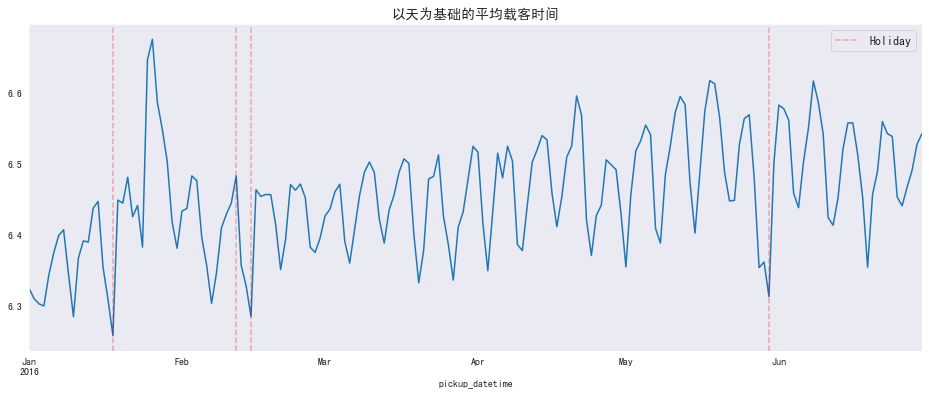

In [35]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

plt.figure(figsize=(16,6))
resample_day.plot(kind='line')
plt.title("以天为基础的平均载客时间",fontsize=14)
for i in resample_holiday.index:
    plt.axvline(i,linestyle='--', color='r',alpha=0.3)
#设置风格和图例
plt.style.use('tableau-colorblind10')
lin1, =plt.plot(resample_holiday.index,resample_holiday.values,linestyle='--', color='r',alpha=0.3)
plt.legend(handles=[lin1],labels=['Holiday'],fontsize=12)

发现：
1. 靠近假期的载客时间有明显变化

2. 正向及负向作用同时存在

In [36]:
near_holiday=[]
for i in (resample_holiday.index-timedelta(days=1)).values:
    near_holiday.append(i)
for i in (resample_holiday.index+timedelta(days=1)).values:
    near_holiday.append(i) 
    
def is_near_holiday(x):
    if x in near_holiday:
        return 1
    else:
        return 0

In [37]:
full['near_holiday']=full.pickup_datetime.apply(is_near_holiday)

用k均值对时间进行聚类，对高峰和非高峰期作区分

以k均值按24个质心分类比直接按小时分类更有区分度

In [38]:
temp=KMeans(n_clusters=24,random_state=5).fit_predict(full.pickup_min.values.reshape(-1,1))
full['pickup_h_cluster']=temp

**处理地点序列：**

由于不同的地区，路况不同，其通行时间也不同

因此接下来要对地区进行分块

In [39]:
full['pickup_cluster']=KMeans(n_clusters=20,random_state=5).fit_predict(full[['pickup_latitude','pickup_longitude']])
full['dropoff_cluster']=KMeans(n_clusters=20,random_state=5).fit_predict(full[['dropoff_latitude','dropoff_longitude']])

D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


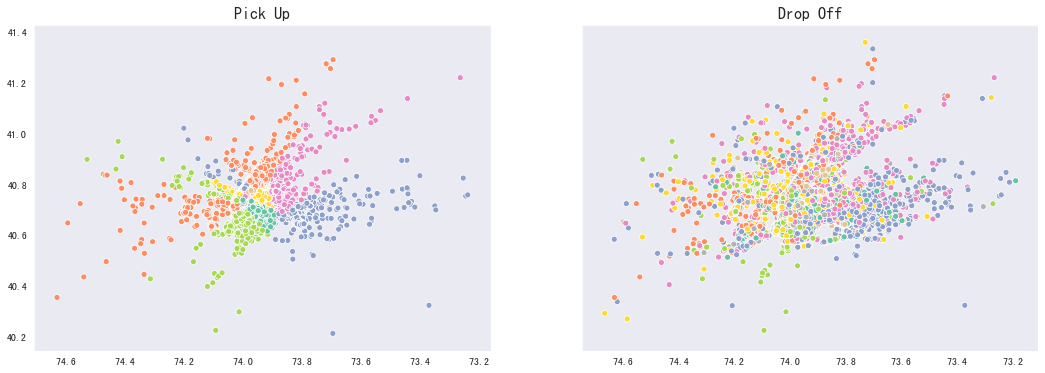

In [40]:
# 为了将所有的店呈现出来，因此要先进行转化（seaborn对于数字的hue显示不完全）
map_trans={1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten',11:'eleven',12:'twelve',
           13:'thirteen',14:'fourteen',15:'fifteen',16:'sixteen',17:'seventeen',18:'eighteen',19:'nineteen',20:'twenty'}
hue_trans=full.pickup_cluster.map(map_trans)

n=int(len(full)/2)
fig,ax=plt.subplots(1,2,sharey=True,figsize=(18,6))
sns.scatterplot(x=full.pickup_longitude[ :n],y=full.pickup_latitude[:n],hue=hue_trans[ :n],palette='Set2',ax=ax[0])
sns.scatterplot(x=full.dropoff_longitude[ :n],y=full.dropoff_latitude[:n],hue=hue_trans[ :n],palette='Set2',ax=ax[1])
ax[0].set(xlabel='',ylabel='')
ax[1].set(xlabel='',ylabel='')
ax[0].set_title(label='Pick Up',fontsize=16)
ax[1].set_title(label='Drop Off',fontsize=16)
ax[0].legend().remove()
ax[1].legend().remove()

可以发现上车地点的区块集中度更高；下车地点则较为分散

这说明多数出租车行程是：在纽约市内坐车向四周出发

平面距离:

In [41]:
full['distance'] = np.sqrt(np.power(full.dropoff_longitude - full.pickup_longitude, 2) + 
                         np.power(full.dropoff_latitude - full.pickup_latitude, 2))

球体距离：

In [42]:
# 利用haversine公式：计算一个球体两点之间的表面距离
def haver_distance(x):
    return haversine((x.pickup_latitude,x.pickup_longitude),(x.dropoff_latitude,x.dropoff_longitude))

full['haver_distance']=full.apply(haver_distance,axis=1)

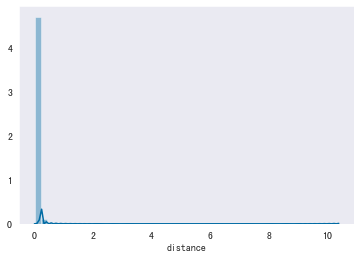

In [43]:
sns.distplot(full.distance)

发现：
1. 有零值
2. 有过大值

作进一步查看

*零值：*

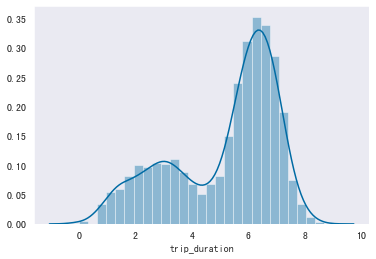

In [44]:
# 查看上、下车地点一直的数据的旅行时间
sns.distplot(full[(full.pickup_latitude==full.dropoff_latitude)&(full.pickup_longitude==full.dropoff_longitude)&(full.index<=len(train.index))]['trip_duration'])

发现上下车地点相同的旅行时间均在10之内，符合实际情况

因此不算作异常值

*过大值：*

Text(0.5, 1.0, '测试集')

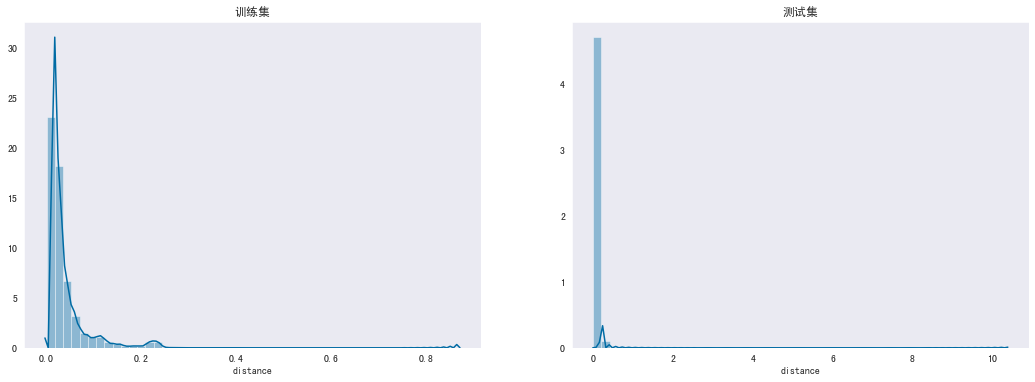

In [45]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(18,6)
sns.distplot(full[full.index<=(len(train)-1)]['distance'],ax=ax[0])
sns.distplot(full[full.index>(len(train)-1)]['distance'],ax=ax[1])
ax[0].set_title('训练集',fontsize=12)
ax[1].set_title('测试集',fontsize=12)



可以看出过大值为测试集的数据，因此这里不作删除处理

因之前距离数据斜较大，在此log化

In [46]:
#单位为km，且为避免零值log化引发的错误加上1m为0.001
full['log_distance']=np.log(full.distance+0.001)

Text(0.5, 1.0, 'log化之前')

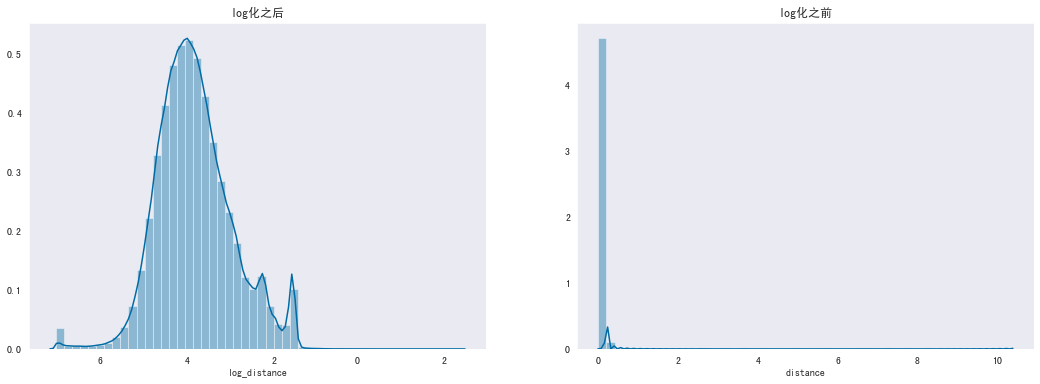

In [47]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(18,6)
sns.distplot(full.log_distance,ax=ax[0])
sns.distplot(full.distance,ax=ax[1])
ax[0].set_title('log化之后',fontsize=12)
ax[1].set_title('log化之前',fontsize=12)

最后对经纬度进行合并，利用PCA的降维功能

In [48]:
combine=PCA(n_components=1)

full['pickup']=combine.fit_transform(full[['pickup_latitude','pickup_longitude']])
full['dropoff']=combine.fit_transform(full[['dropoff_latitude','dropoff_longitude']])

**其余字段**

提取字段“乘客数量分类”

In [49]:
k=pd.cut(full.passenger_count.values,[0,1,4,10],
         labels=['few','noraml','large'],right=True,include_lowest=True)
full['passenger_class']=k

### 3.2.2 特征选择

特征选择为三步：
1. 需要one-hot编码的字段
2. 需要丢弃的字段
3. 贡献度高的字段

1.one-hot编码：

In [50]:
feature_to_dummy=['pickup_h_cluster', 'pickup_cluster', 'dropoff_cluster', 'passenger_class','vendor_id','pickup_d', 'pickup_m']

dummies=pd.DataFrame()
for i in feature_to_dummy:
    k=pd.get_dummies(full[i],prefix=i)
    dummies=pd.concat([dummies,k],axis=1)

In [51]:
full=pd.concat([full,dummies],axis=1)

2.丢弃不用的字段：

In [52]:
feature_to_drop=['dropoff_datetime', 'passenger_count', 'pickup_min','pickup_datetime','id',
                 'pickup_h_cluster', 'pickup_cluster', 'dropoff_cluster', 'passenger_class','vendor_id','pickup_d', 'pickup_m']

full=full.drop(feature_to_drop,axis=1)

3.调试模型后贡献度高的字段

由于本数据集的字段比较紧凑，没有过多的冗余字段

因此这里不进行进一步的舍弃

# 4. 构建模型

## 4.1 模型选择

在训练之前先进行数据标准化

In [53]:
for i in full.columns[:12]:
    if i=='trip_duration':
        continue
    mean,std=full[i].mean(),full[i].std()
    full[i]=(full[i]-mean)/std

分离训练集、验证集和测试集

In [54]:
# 分离训练集和测试集
train_clean=full.iloc[:len(train),]
test_clean=full.iloc[len(train):,]
test_clean=test_clean.drop('trip_duration',axis=1)

In [55]:
# 受到设备性能限制，因此选取部分数据集作为调参数据
train_to_adjust=train_clean.sample(frac=0.08,random_state=5)
# 分离训练集和验证集
train_x,train_ver_x,train_y,train_ver_y=train_test_split(train_to_adjust.drop('trip_duration',1),
                                                         train_to_adjust.trip_duration,
                                                         test_size=0.2,
                                                         random_state=5)

考虑到既有数值类字段也有分类字段

选择随机森林模型

### 4.2 调参

需要调整的参数：
* n_estimators
* max_depth
* max_features
* max_leaf_nodes

 
    


**首先调整过程影响类参数**

随机森林的过程影响类参数为n_estimators

In [56]:
estimator=RandomForestRegressor(criterion='mse',
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=None,
                                verbose=0,
                                warm_start=False,)
param_grid={'n_estimators':list(range(10,171,40))}
grid_search=GridSearchCV(estimator=estimator,
                         param_grid=param_grid)

In [57]:
grid_search.fit(train_x,train_y)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [10, 50, 9

In [58]:
result_n_estimator=pd.DataFrame(grid_search.cv_results_)

In [59]:
result_n_estimator

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,17.259,0.389,0.191,0.008,10,{'n_estimators': 10},0.729,0.709,0.716,0.718,0.008,5
1,84.178,0.448,0.832,0.003,50,{'n_estimators': 50},0.749,0.733,0.737,0.740,0.007,4
2,150.976,0.723,1.470,0.004,90,{'n_estimators': 90},0.752,0.736,0.739,0.742,0.007,3
3,217.162,1.520,2.080,0.028,130,{'n_estimators': 130},0.754,0.737,0.740,0.744,0.008,2
4,282.792,1.515,2.713,0.034,170,{'n_estimators': 170},0.755,0.737,0.740,0.744,0.008,1


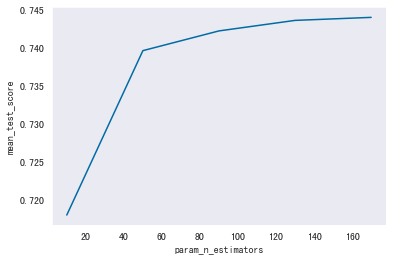

In [60]:
sns.lineplot(x='param_n_estimators',y='mean_test_score',
             data=result_n_estimator[['param_n_estimators','mean_test_score']])

可以看到：
1. 随着n_estimator的数量增加，模型得分越高
2. 得分增量在n_estimator达到30之后开始放缓

因此我们将n_estimator定为170

**调整子模型影响类参数**

先调整maxfeature

In [61]:
# maxfeature默认为'auto',其值为总特征数的开方
np.sqrt(len(train_x.columns))

9.746794344808963

In [62]:
estimator=RandomForestRegressor(n_estimators=100,
                                criterion='mse',
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=None,
                                verbose=0,
                                warm_start=False,)
param_grid={'max_features':list(range(9,26,4))}
grid_search=GridSearchCV(estimator=estimator,
                         param_grid=param_grid)

In [63]:
grid_search.fit(train_x,train_y)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [9, 13, 17, 2

In [64]:
result_maxfeature=pd.DataFrame(grid_search.cv_results_)

In [65]:
result_maxfeature

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,28.669,3.026,1.655,0.025,9,{'max_features': 9},0.740,0.733,0.736,0.736,0.003,5
1,34.169,0.749,1.737,0.117,13,{'max_features': 13},0.747,0.736,0.738,0.740,0.005,4
2,40.554,0.085,1.666,0.007,17,{'max_features': 17},0.747,0.737,0.739,0.741,0.004,3
3,47.136,0.166,1.657,0.008,21,{'max_features': 21},0.750,0.737,0.739,0.742,0.006,2
4,53.861,0.040,1.664,0.007,25,{'max_features': 25},0.750,0.738,0.739,0.742,0.006,1


Text(0.5, 1.0, 'COV of Accuravy with maxfeature')

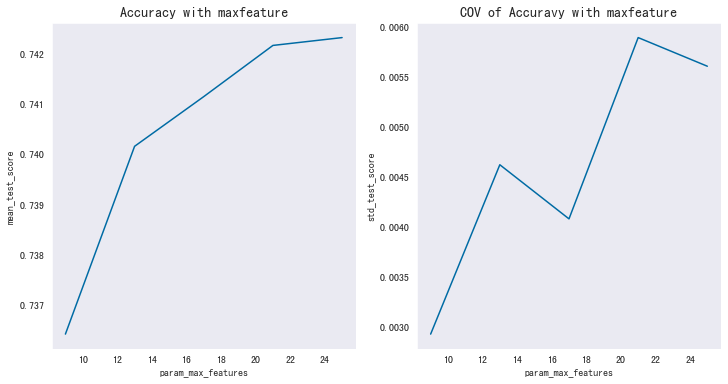

In [66]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(12,6)
sns.lineplot(x='param_max_features',y='mean_test_score',data=result_maxfeature[['param_max_features','mean_test_score']],ax=ax[0])
sns.lineplot(x='param_max_features',y='std_test_score',data=result_maxfeature[['param_max_features','std_test_score']],ax=ax[1])
ax[0].set_title('Accuracy with maxfeature',fontsize=14)
ax[1].set_title('COV of Accuravy with maxfeature',fontsize=14)

可见随着最大特征数量增大：
1. 准确度增大
2. 方差在一开始下降后开始震荡

maxfeature取值26

调整maxdepth

In [67]:
estimator=RandomForestRegressor(n_estimators=100,
                                criterion='mse',
                                max_features=26,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=None,
                                verbose=0,
                                warm_start=False,)
param_grid={'max_depth':list(range(10,111,20))}
grid_search=GridSearchCV(estimator=estimator,
                         param_grid=param_grid)

In [68]:
grid_search.fit(train_x,train_y)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None, max_features=26,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 30, 50, 70, 90, 110]},
             pre_dispatch='2*n_jobs',

In [69]:
result_maxdepth=pd.DataFrame(grid_search.cv_results_)

Text(0.5, 1.0, 'COV of Accuravy with maxdepth')

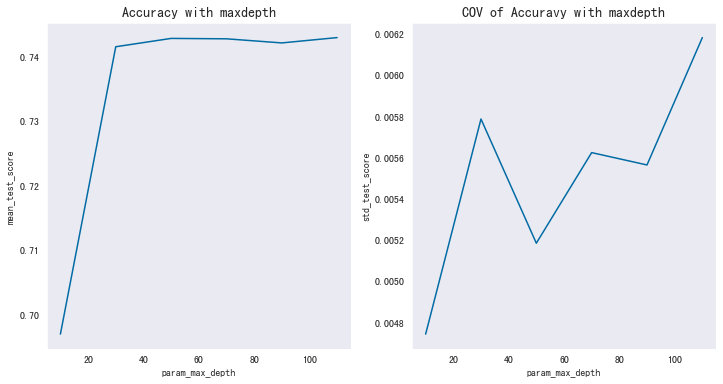

In [70]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(12,6)
sns.lineplot(x='param_max_depth',y='mean_test_score',data=result_maxdepth[['param_max_depth','mean_test_score']],ax=ax[0])
sns.lineplot(x='param_max_depth',y='std_test_score',data=result_maxdepth[['param_max_depth','std_test_score']],ax=ax[1])
ax[0].set_title('Accuracy with maxdepth',fontsize=14)
ax[1].set_title('COV of Accuravy with maxdepth',fontsize=14)

max_depth取90

调整max_leaf_nodes

In [71]:
estimator=RandomForestRegressor(n_estimators=100,
                                criterion='mse',
                                max_depth=90,
                                max_features=26,                                
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=None,
                                random_state=None,
                                verbose=0,
                                warm_start=False,)
param_grid={'max_leaf_nodes':list(range(100,3101,500))}
grid_search=GridSearchCV(estimator=estimator,
                         param_grid=param_grid)

In [72]:
grid_search.fit(train_x,train_y)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=90, max_features=26,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_leaf_nodes': [100, 600, 1100, 1600, 2100, 2600,
                           

In [73]:
result_max_leaf_nodes=pd.DataFrame(grid_search.cv_results_)

Text(0.5, 1.0, 'COV of Accuravy with maxleafnodes')

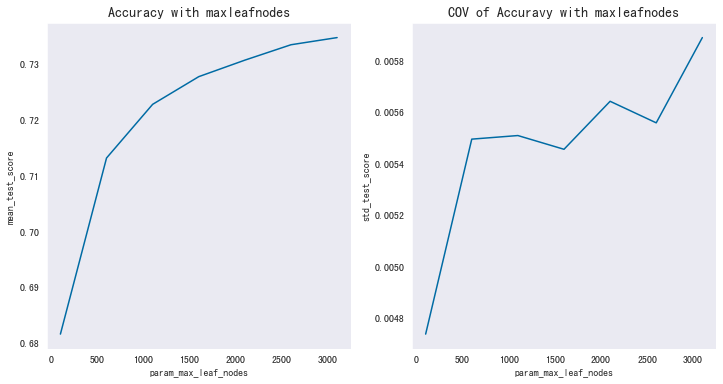

In [74]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(12,6)
sns.lineplot(x='param_max_leaf_nodes',y='mean_test_score',data=result_max_leaf_nodes[['param_max_leaf_nodes','mean_test_score']],ax=ax[0])
sns.lineplot(x='param_max_leaf_nodes',y='std_test_score',data=result_max_leaf_nodes[['param_max_leaf_nodes','std_test_score']],ax=ax[1])
ax[0].set_title('Accuracy with maxleafnodes',fontsize=14)
ax[1].set_title('COV of Accuravy with maxleafnodes',fontsize=14)

调整参数max_leaf_nodes发现：在现有的取值下，准确度最大值低于之前的参数下的准确度

因此max_leaf_nodes取默认值

# 5. 方案实施

In [75]:
train_clean_x=train_clean.drop('trip_duration',axis=1).sample(int(len(train_clean)/2.5))
train_clean_y=train_clean.loc[train_clean_x.index,'trip_duration']

In [76]:
model=RandomForestRegressor(n_estimators=170,max_features=26,max_depth=90)
model.fit(train_clean_x,train_clean_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=26, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=170,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [77]:
predict_pre=model.predict(test_clean)
predict=np.exp(predict_pre)
result=pd.DataFrame({'Id':test.id,'trip_duration':predict})
result.to_csv(r'D:\nyc_taxi__passenger_count_distance_25.csv',index=False)

**结果**

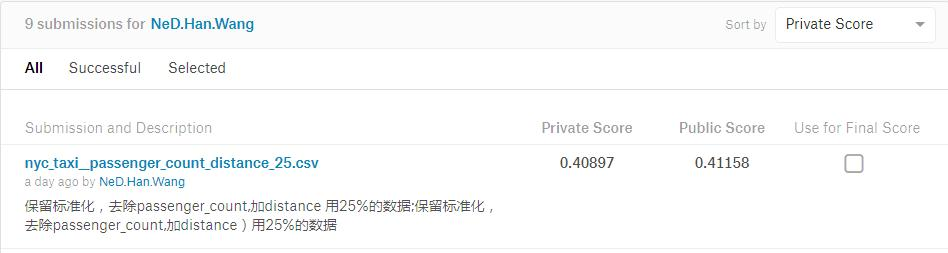

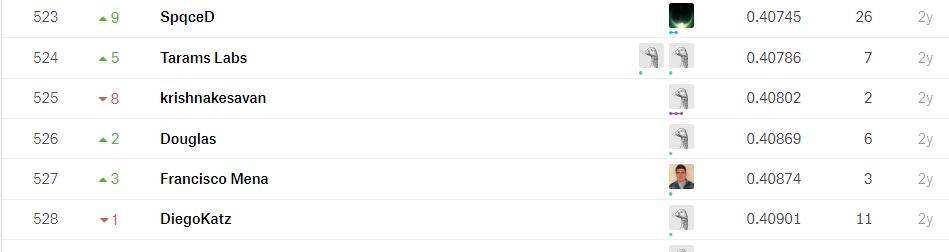

由于是项目以完结，没有直接显示百分位排名

根据分数，排名为528

总人数为1257，为前42%